<span style='font-family: Times; font-size: 2em;'>MIMIC v. 2.2 Database Exploratory Data Analysis</span>


**Veronica Ramirez-Lopera** 

### Objectives: 
To perform an exploratory data analysis for the MIMIC dataset 

### **Table of contents**
- [Introduction](#introduction)
- [Package Requirements](#package_requirements)
- [Data importing](#importing)
- [Data filtering and visualization](#filtering)
- [Conclusions and plan](#conclusions)

## Introduction <a name='introduction'></a>
MIMIC-IV is a freely available electronic health record (EHR) dataset encompassing a decade of patient information (2008-2019) from Beth Israel Deaconess Medical Center [1]. It surpasses its predecessor, MIMIC-III, with a better structure and additional patient information [2, 3].

The dataset draws upon two primary sources: a comprehensive hospital-wide EHR system and an ICU-specific clinical information system [1]. Rigorous de-identification procedures ensure patient privacy while preserving the data's scientific integrity.

It includes vital signs, diagnoses, medications, procedures, and de-identified clinical notes [1]. Researchers leverage MIMIC-IV to investigate disease progression, train machine learning models, and develop clinical decision support tools [1, 2].

As a result, null dates of death indicate the patient was alive at least up to that time point. Inferences regarding patient death beyond one year cannot be made using MIMIC-IV (as per the PhyioNet website) [2]. The majority of patient death information is acquired from hospital records when the individual dies within the BIDMC or an affiliated institute.

MIMIC-IV also offers a dedicated module: MIMIC-IV ECG. This subset focuses specifically on diagnostic electrocardiograms (ECGs) [2]. It includes approximately 800,000 10-second ECG recordings from nearly 160,000 unique patients. Each ECG utilizes 12 leads and is sampled at 500 Hz [3].


## Package requirements <a name='package_requirements'></a>

Notes: 

1- You need to install gcloud if you haven't already. Alternatively, you can use the provided csv files that contain the data.


In [17]:

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import shapiro
import wfdb
import scipy.signal as signal
import torch
import os
from lifelines import KaplanMeierFitter


# Formatting for my pandas dataframes, ignore:

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None) 

# Construct a BigQuery client
client = bigquery.Client()

# Data Importing <a name='importing'></a>
By using SQL, I will import the required data into the local environment and organize it in a pandas dataset. For the purpose of this analysis, I will need:

- subject_id: Unique identifier for each patient, used to link admissions and ECG records.- hadm_id: Identifier for each hospitalization event, allowing differentiation between multiple admissions for the same patient.
- admittime/dischtime: Admission and discharge timestamps to determine the hospitalization period and align ECG events within the correct timeframe.
- admission_type: Type of admission (e.g., emergency, elective) to categorize hospitalizations and assess their impact on ECG frequency.
- admission_location: The location or source of admission (e.g., ER, clinic).
- study_id: Unique identifier for each ECG study, used to track individual ECG events.
- file_name: Name of the ECG file, useful for accessing raw waveform data if needed for deeper analysis.
- ecg_time: Timestamp of when the ECG was performed, helps with determining its relation to the admission period.
- path: File path to the ECG data, allowing retrieval of the raw ECG waveform files for further analysis if required.

In [ ]:

# Data importing 

# Fetch admissions data
'''
With the following code I will fetch both the ecg paths AND the admissions table, but only if the 
ecg was in the context of an admission this is to ensure that the ecgs were not taken during the
same visit, and at two different times in the patients life, which can showcase the dynamic 
changes in the heart that ocur during hospitalizations. 

'''

admissions_query = '''
SELECT 
  a.subject_id,
  a.hadm_id,
  a.admittime,
  a.dischtime,
  a.admission_type,
  a.admission_location,
  a. race,
  b.gender,
  b.anchor_year_group,
  b. anchor_year,
  b. anchor_age,
  b.dod,
  e.study_id,
  e.file_name,
  e.ecg_time,
  e.path
FROM 
  `physionet-data.mimiciv_hosp.admissions` AS a
INNER JOIN
  `physionet-data.mimiciv_hosp.patients` AS b
ON 
  a.subject_id = b.subject_id
LEFT JOIN 
  `physionet-data.mimiciv_ecg.record_list` AS e
ON 
  a.subject_id = e.subject_id
  AND e.ecg_time BETWEEN a.admittime AND a.dischtime                    
'''


# Fetch the admissions data as a DataFrame
admissions = client.query(admissions_query).to_dataframe(create_bqstorage_client=True)

# Save the admissions data to a CSV file

path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\admissions.csv'
admissions.to_csv(path, index=False)

print('\nAdmissions data:')
print(admissions.head())

In [18]:
# Load the admissions data from the CSV file, 

'''
Since running the query is time-consuming, I will save the data to a CSV file and load it from there. 
This approach will also help avoid additional costs and allow for more efficient work.
'''
path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\admissions.csv'
admissions = pd.read_csv(path)


# General Visualization of the dataset

- Drop the missing Values
- visualize the demographic data 

Axes(0.125,0.11;0.698618x0.77)


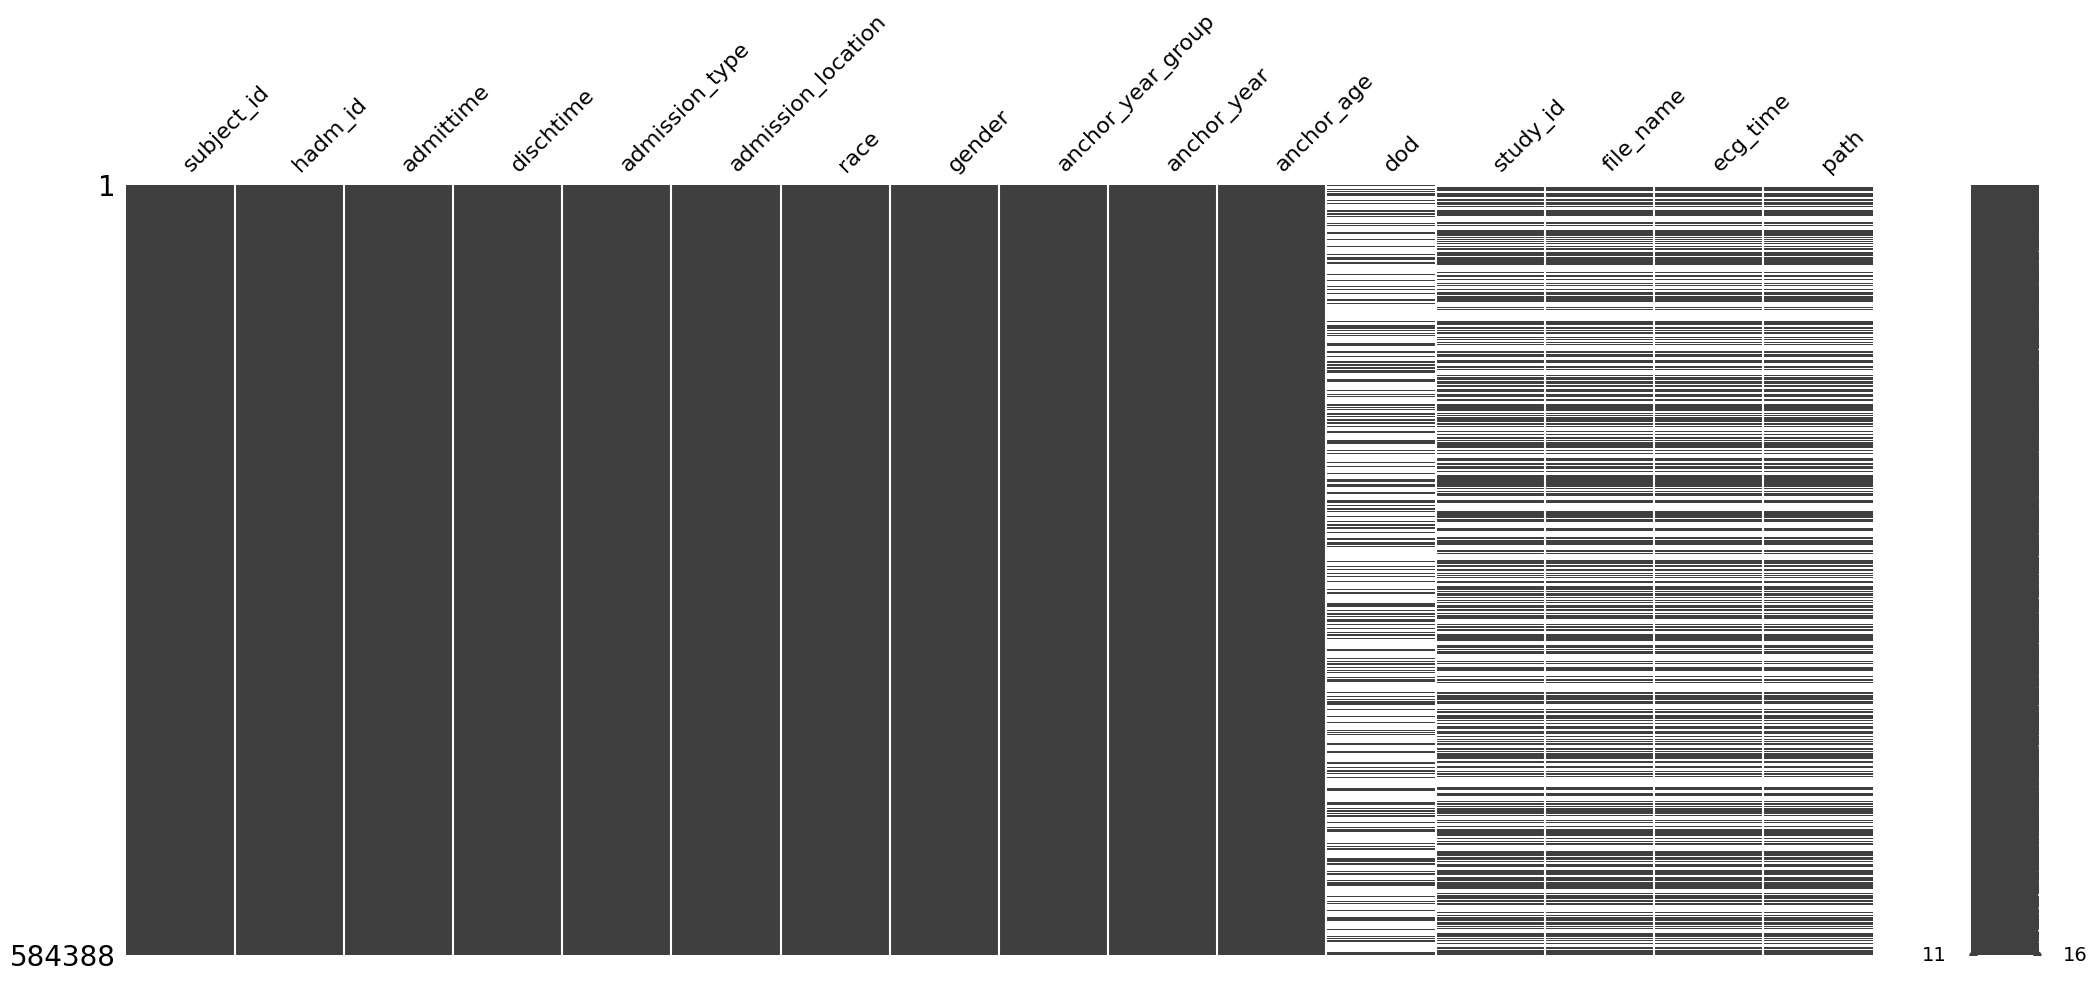

In [ ]:
# Lets visualize the missing values in the admissions data
print(msno.matrix(admissions))


There are missing values in the dod category, which is to be expected due to the fact that most of the population was still alive up to three years after their admission. 


The missing values in the rest of the categories mean that not every admission had an ECG associated.

# Understanding the data
Lets visualize the data and add the length of stay

In [19]:
#Organize the data so we can start the analysis

# 1.Convert the 'admittime' and 'dischtime' columns to datetime objects
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['length_of_stay_(days)'] = admissions['dischtime'] - admissions['admittime']             # Calculate the length of stay an add it as a new column
admissions['length_of_stay_(days)'] = admissions['length_of_stay_(days)'].dt.days                   # Convert the length of stay to days
print(admissions['length_of_stay_(days)'].describe())

# 2. Create a separate table that only contains the unique patients in subject_id
''' 
The reason for this is that we want to have a unique patient per row, and not have the same patient
appear multiple times in the data for the demographic analysis.
'''
patients = admissions[admissions.duplicated(subset='subject_id') == False]                          # Filter out the repeated patients
print(patients.head())

# 3. Create a new column 'age' that calculates the age of the patient at the time of admission
''' 
This is done by substracting the anchor_year_group from the anchor_age to calculate the birth year, 
and then substracting the birth year from the admission year to get the age.

 age = hospital admission time - anchor_year + anchor_age
'''
patients['age'] = patients['admittime'].dt.year - patients['anchor_year'] + patients['anchor_age']

print(patients.head())

count    584388.000000
mean          6.659261
std          12.206168
min          -1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         295.000000
Name: length_of_stay_(days), dtype: float64
   subject_id   hadm_id           admittime           dischtime  \
0    10106244  26713233 2147-05-09 10:34:00 2147-05-12 13:43:00   
4    13700703  20448599 2172-09-25 01:01:00 2172-10-03 13:25:00   
5    15443666  27961368 2168-12-30 23:30:00 2169-01-05 16:02:00   
6    16299919  26977065 2193-05-15 08:37:00 2193-05-17 16:03:00   
7    19596808  26675460 2128-06-04 16:13:00 2128-06-05 11:36:00   

      admission_type  admission_location                    race gender  \
0       DIRECT EMER.  PHYSICIAN REFERRAL                   WHITE      F   
4  OBSERVATION ADMIT      EMERGENCY ROOM                   WHITE      F   
5  OBSERVATION ADMIT      EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
6  OBSERVATION ADMIT      EMERGENCY ROOM  BLACK/AFRICAN AMERICAN     

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_24888\2586320800.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients['age'] = patients['admittime'].dt.year - patients['anchor_year'] + patients['anchor_age']


In [5]:
# Update the admissions csv with these changes and save the patients data to a new csv file
path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\new_admissions.csv'
admissions.to_csv(path, index=False)
patients_path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\patients.csv'
patients.to_csv(patients_path, index=False)

In [ ]:
# Count the number of deceased and unique patients 
unique_count = admissions['subject_id'].nunique()
dead_counts = patients['dod'].apply(lambda x: 'dead' if pd.notna(x) else 'alive')
dead_counts_summary = dead_counts.value_counts()

print(f'There are {unique_count} unique patients in the admissions data, and:')
print(f'{dead_counts_summary.get("dead", 0)} are dead.')
print(f'{dead_counts_summary.get("alive", 0)} are alive.')



There are 180733 unique patients in the admissions data, and:
27980 are dead.
152753 are alive.


In [ ]:
# Shapiro-Wilks test for normality of the age feature

from scipy.stats import shapiro
stat, p = shapiro(patients['age'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret the test
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian ')
else:
    print('Sample does not look Gaussian ')
    
patients['age'].median()
    
    

Statistics=0.968, p=0.000
Sample does not look Gaussian 


c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 180733.
  res = hypotest_fun_out(*samples, **kwds)


58.0

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_25188\1069517694.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(patients['age'], bins=30, kde=True, ax=axes[0], palette='pastel')


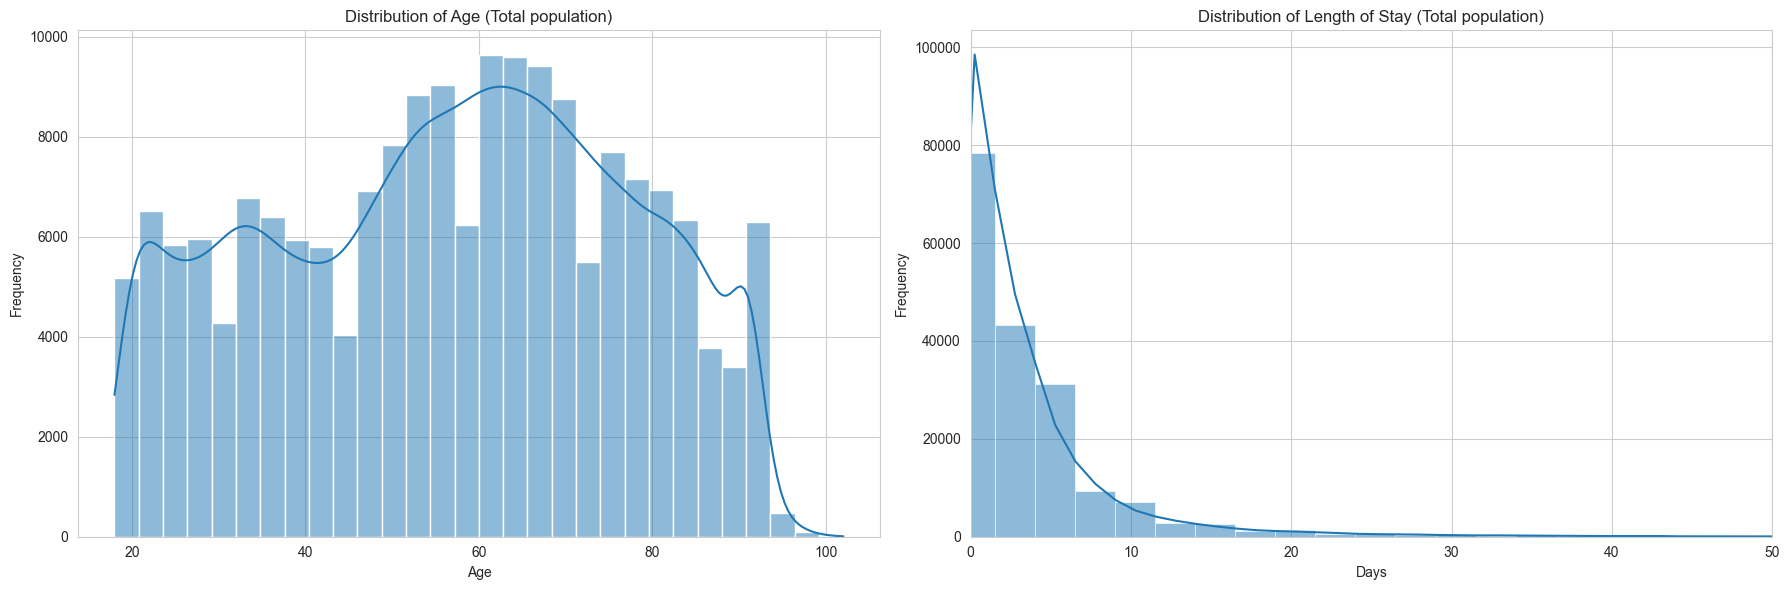

In [ ]:
# Lets visualize the demographic data (patients that have at least one admission)
'''
Having at least one admission is a requirement to later visualize the diagnosis data.
'''

# Set the style of the plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the distribution of the anchor_age variable
sns.histplot(patients['age'], bins=30, kde=True, ax=axes[0], palette='pastel')
axes[0].set_title('Distribution of Age (Total population)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot the distribution of the length_of_stay variable 
'''  
The length of stay is the number of days a patient stays in the hospital.
'''
sns.histplot(patients['length_of_stay_(days)'], bins=100, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Length of Stay (Total population)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 50)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


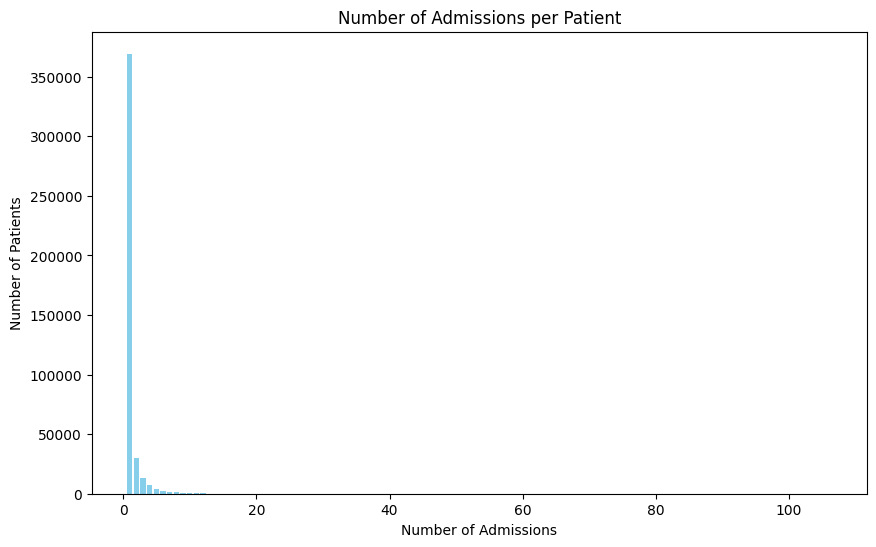

In [16]:
# Lets visualize the amount of admissions per patient

admissions_per_patient = admissions['hadm_id'].value_counts().value_counts().sort_index()

#Plot the number of admissions per patient
plt.figure(figsize=(10, 6))
plt.bar(admissions_per_patient.index, admissions_per_patient.values, color='skyblue')
plt.title('Number of Admissions per Patient')
plt.xlabel('Number of Admissions')
plt.ylabel('Number of Patients')
plt.show()

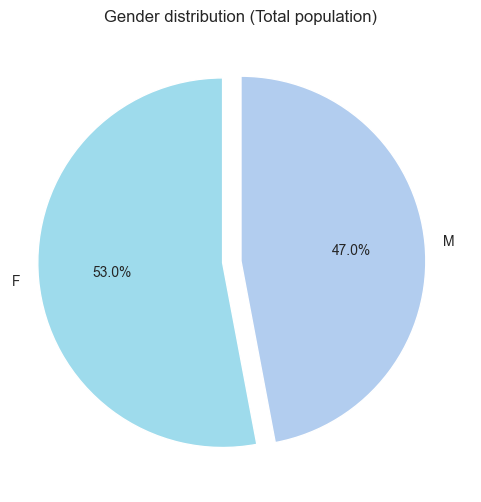

In [ ]:
# Now lets do this for the gender

#do a pie chart 

plt.figure(figsize=(6, 6))
patients['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0.1, 0), \
    shadow=False, colors=['#9edbec', '#b2cdef'])
plt.title('Gender distribution (Total population)')
plt.ylabel('')
plt.show()


C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_23432\171999476.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data =common_race, ax=axes[0], palette='viridis')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_23432\171999476.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_23432\171999476.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dead_counts, ax=axes[1], palette='viridis')


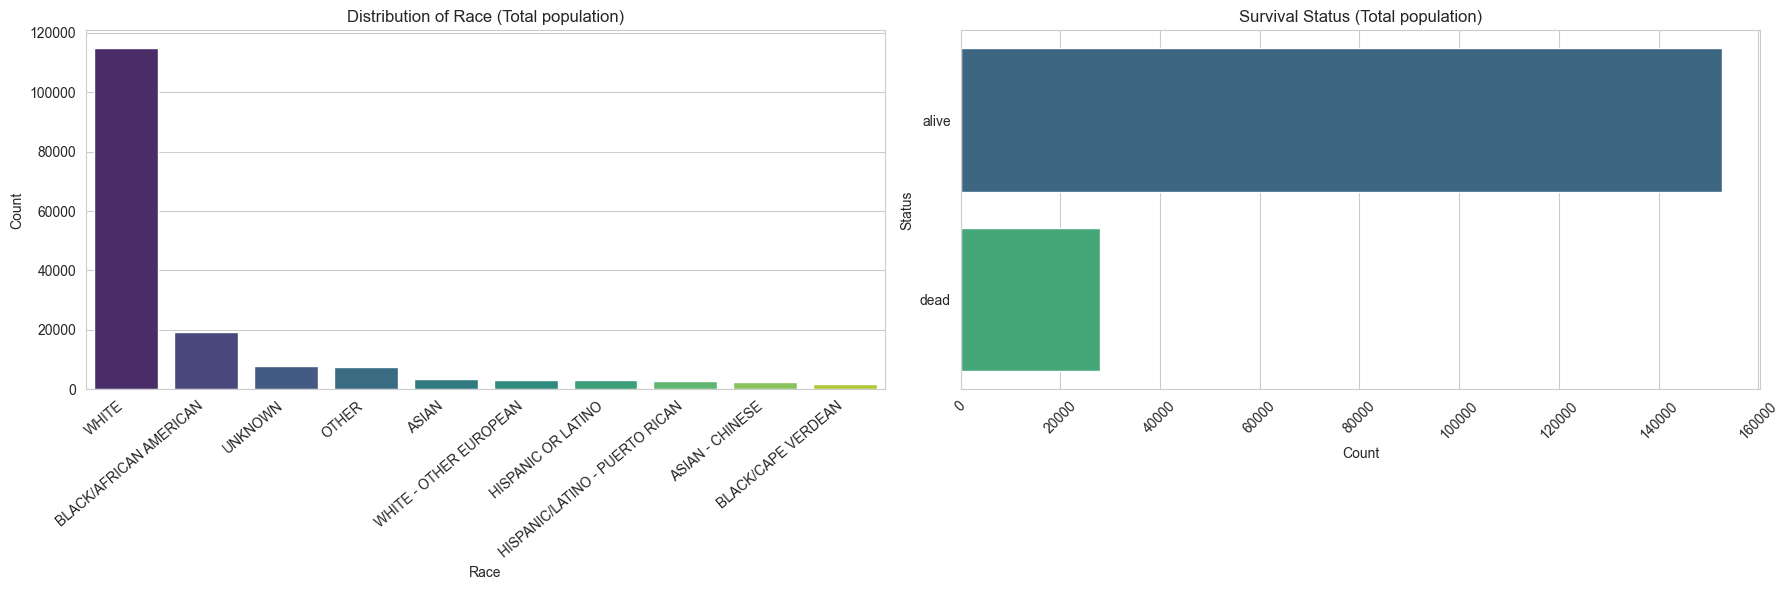

In [ ]:
# Lets graph a barplot for race and dod

fig, axes = plt.subplots(1, 2, figsize=(18, 6) )

# Plot the distribution of the 'race' variable (only the 10 most common), and exclude missing values
common_race = patients['race'].value_counts().head(10).dropna()

sns.barplot(data =common_race, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Race (Total population)')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=40)
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')

# Plot the distribution of 'dod'
sns.countplot(data=dead_counts, ax=axes[1], palette='viridis')
axes[1].set_title('Survival Status (Total population)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Status')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


# Conclusions

Demographic Data:

    The age distribution of patients shows a non-Gaussian pattern, confirmed by the Shapiro-Wilks test (statistic = 0.968, p < 0.05). The median age is 58 years, indicating a significant portion of patients are middle-aged or older.
    The gender distribution shows a roughly even split between male and female patients.

Length of Stay:

    The distribution of the hospital length of stay shows that most patients are hospitalized for a short duration, with the majority staying between 1 and 7 days. However, there are outliers with stays as long as 295 days.

Mortality:

    Out of 180,733 unique patients, 27,980 were deceased, while 152,753 were alive. This mortality data reflects the severe conditions of many patients admitted to the ICU or hospital wards.

Race Distribution:

    Race distribution data reveals that the most common races are "White". There is not a lot of diversity, which makes this dataset not so generalizable for other populations

ECG Data:

    The dataset contains 12-lead ECG data, captured at 500 Hz. This subset of the data offers valuable insights for researchers looking into cardiac health and disease progression. However, ECG records were not available for every patient, as seen from missing values in the dataset.